<a href="https://colab.research.google.com/github/tomascortes/Concavity-Metrics/blob/main/Copia_de_Concavity_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concavity metrics

In [ ]:
from google.colab import files
uploaded = files.upload()
print("Files uploaded")

Saving input.xlsx to input (1).xlsx
Files uploaded


# Proccessing Code

## read data

In [1]:
pip install openpyxl==3.0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 242 kB 9.4 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


In [2]:
#@title
import string
import os
import sys
from openpyxl import Workbook, load_workbook
from io  import BytesIO
from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill, Font

class MoreValuesThanTimeStamps(Exception):
    """Raised when there are missing timestamps """
    pass


def path_selector() -> string:
    # Declare the dictionry options
    options = dict()
    counter = 1

    # Print all the excel files in directory
    files = os.listdir("./")
    for file in files:
        if ".xlsx" in file:
            options[counter] = file
            print(f"{counter})", end="")
            print(file)
            counter += 1
    # Ask for input
    answer = input("Write number of the file to be selected an press enter \n")
    while not answer.isdigit():
        print("\nRemember to write just a number")
        answer = input("Write number of file to be selected an press enter \n")
    answer_number = int(answer)
    return options[answer_number]


def read_file(file, work_sheet: str=None) -> tuple:
    """recives a path of a excel file and return a tuple of two lists, 
    corresponding to time and Values"""
    wb = Workbook()
    wb = load_workbook(filename=BytesIO(file))
    if work_sheet:
        ws = wb[work_sheet]
    else:
        ws = wb.worksheets[0]

    output_time = []
    output_values = []

    for row in ws.rows:
        output_time.append(row[0].value)
        output_values.append(row[1].value)

    start_x = round(ws.cell(2, 3).value, 2)
    finish_x = round(ws.cell(2, 4).value, 2)


    output_time.pop(0)
    output_values.pop(0)

    # Sometimes the data read Nones at the end,
    # there should be no Nones in the middle

    for i in range(len(output_time)):
        if output_time[i] == None:
            output_time = output_time[:i]
            break

    for i in range(len(output_values)):
        if output_values[i] == None:
            output_values = output_values[:i]
            break
    if len(output_values) > len(output_time):
        raise MoreValuesThanTimeStamps("There are more input values than time values")
    elif len(output_values) != len(output_time):
        output_time = output_time[:len(output_values)]
    return (output_time, output_values, start_x, finish_x)

def get_verbose() -> bool:
    n = len(sys.argv)
    if n >= 2:
        return sys.argv[1] == "p"
    return False


## output data 

In [3]:
#@title
def update_excel(big_dist_data: dict, mid_dist_data: dict):
    """recives a list of lists with shape:
    [integral_value, start_integral, end_integral]
    and returns and creates an excel file with the data in the
    output path. Creates output directory if it doesn't exist."""
    PATH = "input.xlsx"
    # Create workbook
    wb = Workbook()
    wb = load_workbook(filename=PATH, read_only=False)
    ws = wb.worksheets[0]

    ##General metrics##
    for i, key in enumerate(["slope start-finish", "upper area", "downer area"]):
        ws.cell(row=6, column=6 + i).value = key
        ws.cell(row=6, column=6 + i).fill = PatternFill(start_color="75E6DA", end_color="75E6DA", fill_type = "solid")
        ws.cell(row=7, column=6 + i).value = big_dist_data[key]
        big_dist_data.pop(key)

    # Write first set of data
    title_cell = ws.cell(row=1, column=5)
    title_cell.value = "Bigger Distance Pivot"
    title_cell.fill = PatternFill(start_color="FF4A4A", end_color="FF4A4A", fill_type = "solid")
    title_cellfont = Font(size=12)
    for i, (name, value) in enumerate(big_dist_data.items()):
        ws.cell(row=1, column=i+6).value = name + " BDP"
        ws.cell(row=1, column=i+6).fill = PatternFill(start_color="75E6DA", end_color="75E6DA", fill_type = "solid")
        ws.cell(row=2, column=i+6).value = value

    

    # Write second set
    title_cell = ws.cell(row=3, column=5)
    title_cell.value = "Middle Distance Pivot"
    title_cell.fill = PatternFill(start_color="FF4A4A", end_color="FF4A4A", fill_type = "solid")
    #Copied and pasted from excel file

    for i, (name, value) in enumerate(mid_dist_data.items()):
        ws.cell(row=3, column=i+6).value = name + " MDP"
        ws.cell(row=3, column=i+6).fill = PatternFill(start_color="75E6DA", end_color="75E6DA", fill_type = "solid")
        ws.cell(row=4, column=i+6).value = value

    for col in ws.columns:
        column = col[0].column_letter   # Get the column name
        ws.column_dimensions[column].width = 20
    # Save excel file
    wb.save(PATH)

## metrics

In [4]:
#@title
from cmath import inf
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#@title

def get_areas(start,finish, dict_curve) -> tuple:
    """Return the uper and downer areas of the curve"""
    slope = (start[1] - finish[1])/(start[0]-finish[0])
    line_y = lambda x: slope*(x - start[0]) + start[1]
    #Compare the first and second lower keys from the dict_curve
    dic_iter = iter(dict_curve)
    first = next(dic_iter)
    second = next(dic_iter)
    dx = second-first

    upper_area = 0
    downer_area = 0
    for time, val in dict_curve.items():
        if time > start[0] and time < finish[0]:
            dist = line_y(time) - val
            if dist > 0:
                plt.plot([time, time], [val, line_y(time)], color="green")
                upper_area += dist*dx
            else:
                plt.plot([time, time], [val, line_y(time)], color="blue")
                downer_area -= dist
    return upper_area, downer_area

def get_triangle_area(a,b,c) -> float:
    """Return the area of a triangle with sides a,b,c"""
    return 1/2*(a[0]*(b[1] - c[1]) + b[0]*(c[1] - a[1]) + c[0]*(a[1] - b[1]))

In [6]:
#@title
#Get the points in the curve with the bigger and smaller angle
def get_angle(first, middle, last):
    ba = first - middle
    bc = last - middle

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def get_bigger_angle(start,finish, dict_curve):
    """Not usefull"""
    max_angle = -1
    max_angle_time = 0
    min_angle = 361
    min_angle_time = 0
    for time, value in dict_curve.items():
        if time > finish[0]:
            break
        angle = get_angle(start, [time, value], finish)
        if angle < min_angle:
            min_angle = angle
            min_angle_time = time
        if angle > max_angle:
            max_angle = angle
            max_angle_time = time
    return max_angle, min_angle, max_angle_time, min_angle_time

In [7]:
#@title
def get_distance(start:np.array, finish:np.array, point:np.array) -> float:
    """Return the distance between the point and the line defined by the start and finish points"""
    return np.linalg.norm(np.cross(finish-start, start-point))/np.linalg.norm(finish-start)


def get_bigger_distance(start,finish, dict_curve) -> tuple:
    """Get the bigger distance between the real curve and the start-finish line, absolute and relative"""
    slope = (finish[1] - start[1])/(finish[0]-start[0])
    
    right_dist = -inf 
    left_dist = inf
    right_dist_time = 0
    left_dist_time = 0
    for time, val in dict_curve.items():
        if time >= finish[0]:
            break
        if time < start[0]:
            continue

        dist = get_distance(start, finish, np.array([time, val]))
        # compare if its up or down from the base line
        if val < slope*(time-start[0]) + start[1]:
            dist = -dist
        if dist > right_dist:
            right_dist = dist
            right_dist_time = time
        if dist < left_dist:
            left_dist = dist
            left_dist_time = time

    #Normilize the distances to percentage of the total distance
    if right_dist > -left_dist:
        big_dist = right_dist
        big_dist_time = right_dist_time
    else:
        big_dist = -left_dist
        big_dist_time = left_dist_time

    big_dist_norm = 100 * big_dist / math.sqrt((finish[0] - start[0])**2 + (finish[1] - start[1])**2)
    return big_dist, big_dist_norm,  big_dist_time


## Ploting

In [8]:
#@title
def plot_line(points_list, label=None, color=None):
    """Recives list with two points and plot the line between them"""
    plt.plot([x[0] for x in points_list], [x[1] for x in points_list], label=label, color=color)



def plot_three_points(first, middle, last, labels=False, color=None):
    if labels:
        plot_line([first, middle], label=labels, color=color)
        plot_line([middle, last], label=labels, color=color)
    else:
        plot_line([first, middle], color=color)
        plot_line([middle, last], color=color)

def plot_quintiles_lines(start, finish, f_x):
    max_time = finish[0]
    colors = ["blue", "green", "orange"]
    
    for i in range(3):
        x_time = round((i + 1)*max_time/5,2) + start[0]
        plot_three_points(start, (x_time, f_x[x_time]),finish, labels=False, color=colors[i])
        plt.plot(x_time, f_x[x_time], marker="o", markersize=5,  color=colors[i])

def plot_lines_to_middle(start_point, finish_point, f_x, color=None):
    middle_time = round((start_point[0] + finish_point[0])/2, 2)
    middle_point = [middle_time, f_x[middle_time]]
    plot_three_points(start_point, middle_point, finish_point, color=color)

## Proccess function

In [9]:
#@title
def process_input(ex_path, verbose=False):
    #Code to select the path 
    time, curve, start_x, finish_x = read_file(ex_path)
    
    f_x = dict(zip([round(x, 2) for x in time], curve))

    start = np.array([start_x, f_x[start_x]])
    finish = np.array([finish_x, f_x[finish_x]])
    
    ### Indexes ###
    best_distance_index = {}
    ## Pivot on bigger distance to the start-finish line ##
    # Distance
    big_dist, big_dist_norm,  big_dist_time =  get_bigger_distance(start, finish, f_x)
    best_distance_index["bigger distance"] = big_dist_time
    best_distance_index["bigger distance norm (%)"] = big_dist_norm
    best_distance_index["bigger distance time"] = big_dist_time
    best_distance_index["% time before pivot"] = 100*(big_dist_time - start[0])/(finish[0] - start[0])
    distance_point = np.array([big_dist_time, f_x[big_dist_time]])


    #Angle in bigger distance
    max_ang = get_angle(start, distance_point, finish)
    best_distance_index["angle"] = max_ang

    # Area
    upper_area, downer_area = get_areas(start, finish, f_x)
    best_distance_index["upper area"] = upper_area
    best_distance_index["downer area"] = downer_area
    best_distance_index["triangle area"] = get_triangle_area(
        start, 
        distance_point, 
        finish)
    # slopes
    best_distance_index["slope start-pivot"] = (distance_point[1] - start[1])/(distance_point[0] - start[0])
    best_distance_index["slope pivot-finish"] = (finish[1] - distance_point[1])/(finish[0] - distance_point[0])
    best_distance_index["slope start-finish"] = (finish[1] - start[1])/(finish[0] - start[0])

    ## Pivot on middle values of the data ##
    middle_distance_index = {}
    mid_time = round((start[0] + finish[0])/2, 2)
    mid_point = np.array([mid_time, f_x[mid_time]])

    # Distance
    middle_distance_index["distance"] = get_distance(start, finish, mid_point)
    middle_distance_index["distance norm (%)"] = 100*get_distance(start, finish, mid_point)/math.sqrt((finish[0] - start[0])**2 + (finish[1] - start[1])**2)
    middle_distance_index["distance time"] = mid_time
    middle_distance_index["% time before pivot"] = 100 * (mid_time - start[0]) / (finish[0] - start[0])

    # Angle in middle
    middle_distance_index["angle"] = get_angle(
        first=start, 
        middle=mid_point, 
        last=finish)

    # Triangle Area in middle
    middle_distance_index["triangle area"] = get_triangle_area(start, mid_point, finish)
    middle_distance_index["slope start-pivot"] = (mid_point[1] - start[1])/(mid_point[0] - start[0])
    middle_distance_index["slope pivot-finish"] = (finish[1] - mid_point[1])/(finish[0] - mid_point[0])

    update_excel(best_distance_index, middle_distance_index)

    if verbose:
        # Print results big distance
        print("Bigger distance: {} at {}".format(big_dist, big_dist_time))
        print("angle: {} at {}".format(max_ang, big_dist_time))
        print("Upper area: {}".format(upper_area))
        print("Downer area: {}".format(downer_area))
        print("Triangle area: {}".format(best_distance_index["triangle area"]))

        print("-"*20)
        # Print results middle distance
        print("Middle distance: {} at {}".format(middle_distance_index["distance"], mid_time))
        print("angle: {} at {}".format(middle_distance_index["angle"], mid_time))
        print("Triangle area: {}".format(middle_distance_index["triangle area"]))
        print("Slope 1: {}".format(middle_distance_index["slope start-pivot"]))
        print("Slope 2: {}".format(middle_distance_index["slope pivot-finish"]))

        ## Ploting funcionts
        plot_line([start, finish], label="start to finish", color="orange")
        plot_three_points(start, [big_dist_time, f_x[big_dist_time]], finish, labels="Big distance", color="red")
        plt.plot(big_dist_time, f_x[big_dist_time], marker="o", markersize=5,  color="red", label="Pivot big distance")
        plt.plot(mid_time, f_x[mid_time], marker="o", markersize=5,  color="blue", label="Middle")

        #Basic graph
        plt.plot(time, curve)
        plt.axis([0, time[-1], 0, max(curve)+2])
        plt.legend()
        plt.show()


# Ejecutar para procesar

Bigger distance: 0.24640966019626212 at 0.67
angle: 170.53411036207623 at 0.67
Upper area: 0.8253896173076921
Downer area: 3.924864230769237
Triangle area: 0.8815244649999991
--------------------
Middle distance: 0.24103434840158744 at 0.7
angle: 170.26141298626564 at 0.7
Triangle area: 0.8622944199999996
Slope 1: -9.995653846153845
Slope 2: -3.6177365384615383


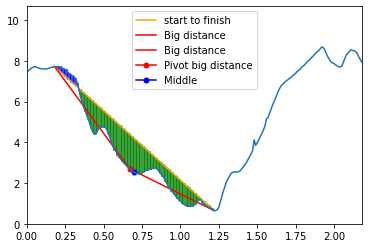

In [ ]:
process_input(uploaded["input.xlsx"], verbose=True)

# Descargar

In [ ]:
files.download('input.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>